In [1]:
# Import statements

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import os

import nltk

plt.rcParams["font.size"] = 16


from sklearn.cluster import DBSCAN
from wordcloud import WordCloud
from yellowbrick.cluster import SilhouetteVisualizer

from sentence_transformers import SentenceTransformer

import regex as re
from bs4 import BeautifulSoup

import io

import requests
from pypdf import PdfReader

# UBC Salaries Across Gender, Department, and Job Title

## Introduction

The primary objective of this project is to develop skills in data wrangling, machine learning, and Tableau. A secondary goal is to create a Tableau dashboard for visualizing University of British Columbia (UBC) faculty salaries based on gender, department, and job title.

To prioritize learning, rather than directly requesting salary data from UBC by department, job title, and gender, I will rely on the annual PDF of salary data released by UBC, along with information from UBC's faculty directory and global baby name datasets.

The project involves several steps: gathering and cleaning salary data, collecting and cleaning department and job title data, making gender predictions for each faculty member, and ultimately visualizing the cleaned data through a Tableau dashboard.

This approach incorporates tasks such as scraping, clustering, and data transformation, offering an in-depth exploration of data manipulation techniques and fostering a comprehensive understanding of the intricacies involved in data wrangling.

## Contents

The following list is how the rest of this project will unfold:

- Data Collection and Cleaning
    - Salary Data
    - Department and Job Title Data
- Gender Prediction
- Data Visualization
- Conclusion

## Data Collection and Cleaning

### Salary Data

We can use the PDF salary information that UBC releases every year. The salary information is retrieved from the following website: [UBC Financial Reports](https://finance.ubc.ca/reporting-planning-analysis/financial-reports). The first step is to go to this website and find the links for years with available salary data.

Above we can see the years with available salary information.

Next, I will create a function that when given a link, will return the text from the link in string form.

Now, I will create a function that can take the salary data in string form, clean it up, and return a dataframe with the columns: `First Name`, `Last Name`, `Remuneration`, `Expenses`, and `Year`.

Now I will loop through the salary data links I collected, clean up the data for each year, and combine the data into one dataframe. 

Below you can see a recent and less recent section of the data.

In [6]:
salary_data.head()

,Last Name,First Name,Remuneration,Expenses,Year
0,Aamodt,Tor,193153.0,"5,597",2023
1,Abanto Salguero,Arleni Karina,107723.0,393,2023
2,Abbassi,Arash,109136.0,82,2023
3,Abdalkhani,Arman,101829.0,-,2023
4,Abdi,Ali,238203.0,"2,981",2023


In [7]:
salary_data.tail()

,Last Name,First Name,Remuneration,Expenses,Year
6219,Zumbo,Bruno,294953.0,"10,102",2020
6220,Zumpano,Franco,94463.0,420,2020
6221,Zumrawi,Abdel Azim,98145.0,-,2020
6222,Zwicker,Jill,145343.0,"12,523",2020
6223,Zysk,Eva,93058.0,"2,489",2020


Also, now that the department and title data has been merged onto the salary data, to try and maintain consistency over the years names will be shortened. For example, "A Bobby" will be shortened to "Bobby" and "Anne Michele" will be shortened to "Anne".

Now we have clean salary data for UBC staff members. I will export this data so that it is available for anyone to use.

## Predicting Gender

Including gender data will allow for an interesting analysis of salary separated by gender. There is a well known pay gap between male and female employees around the world so it will be interesting to see if this gap shows up in the UBC faculty population as well. As mentioned in the introduction, requesting gender data from UBC would create the most accurate dataset. Instead, in order to practice natural language processing and data wrangling, I will attempt to predict gender values based on global gender data. Since these predictions may not be accurate, it is important to be skeptical of any hard conclusions drawn from analysis on this data.

Also, the only gender labels will be Female and Male which is not representative of the spectrum of genders that exist in the world.

### Using corpus

The easiest and quickest way to estimate the gender of the UBC faculty without asking UBC for the information is probably to a corpus with names and genders. Then for each name, I find whether there are more associated girl or guy names in the corpus and the result will be the predicted gender.

First, I will read in Canadian baby name data.

Then, I will find the total number of baby names split by sex and name (VALUE), as well as the total number of baby names just split by name (TOTAL VALUE).  

Now, I will complete the same process with an american baby name dataset, making sure the american data is in the same format as the Canadian data.

The next step is to combine American and Candian data into one large dataset.

Now, for each name I will find which sex has the highest percentage of observations (`Accuracy`) and only keep that sex in the dataset.

Above we can see that names with accuracy close to 0.5 are names that are often used for males and females, while names with accuracy 1.0 are almost always used for just one sex.

After some investigation, I noticed that there were quite a few names of Indian origin in the UBC faculty dataset that were not included in our name corpus. Therefore, I will add names with Indian origin to the name corpus. This step wasn't integrated into the above process because this Indian name dataset does not have a 'counts' or 'value' column to determine sex `Accuracy`. Therefore, the accuracy column for this data will be filled with a fairly arbitrary value of 0.85.

Now I will combine the Indian name data with the previous name dataset to create a more complete name corpus. I will only add names from the Indian name dataset that don't already exist in the data.

Next, I will determine what the percentage of the names in the UBC dataset is that we can match to a sex using our name corpus. I will also create a dataset with UBC faculty members that still need a sex prediction.

I was able to match 92% of the names in the UBC salary dataset with my corpus! However, there are still quite a few names that need gender predictions. For this task, I will use the nltk package.

In [55]:
pop_df_needs_predictions['First Name']

6            Fatawu
12           Tamiza
14           Purang
15            Ninan
23             Reto
            ...    
28000        Youwen
28003        Qinhua
28012       Fahimeh
28013    Bingshuang
28016        Zdenek
Name: First Name, Length: 2163, dtype: object

### Using nltk

To predict the gender for the rest of the names, I will use natural language processing, specifically the nltk package. I will also use the name corpus I have put together as the training data.

The first step is feature engineering. The features I will use are the last, two last, three last, four last, and five last letters in the name. This can capture patterns such as the four last letters 'etta' more often being used for girls names than boys names. 

In [56]:
# Return features of a name to be fed into our model
def gender_features(word):
    word = word.lower()
    return {'last_5_letters': word[-5:], 'last_two_letters': word[-2:],
            'last_letter': word[-1:], 'last_3_letters': word[-3:], 'last_4_letters': word[-4:], 'name': word}

In order to evaluate how well this gender classifier model works, I will shuffle the name corpus, apply feature engineering to the dataset, and then split it into training data and testing data. 

In [57]:
# shuffle our data
name_corpus = name_corpus.sample(frac=1,random_state=123)

In [58]:
# collect features for each name in our data
featuresets = [(gender_features(row['First name at birth']), row['Sex at birth']) for (index, row) in name_corpus.iterrows()]

In [59]:
# split the shuffled data into train and test sets
train_set, test_set = featuresets[3157:], featuresets[:3157]

Next, I will train the classifier on the training data.

In [60]:
# train our classifier with the train set
classifier = nltk.NaiveBayesClassifier.train(train_set)

Now, I can score the model with the test set to see how accurate the classifier is.

In [61]:
# score our classifier with the test set
accuracy = round(nltk.classify.accuracy(classifier, test_set),2)
accuracy

0.85

85 percent accuracy is pretty good. However, the accuracy on the actual data is likely lower that 85 since the actual data contains more unique, unusual names that were not found in our name corpus.

Below we can check which features are most informative for our classifier.

In [62]:
# print out most informative features for the classifier
classifier.show_most_informative_features()

Most Informative Features
          last_4_letters = 'isha'         Female : Male   =    310.2 : 1.0
          last_3_letters = 'ena'          Female : Male   =    264.0 : 1.0
          last_4_letters = 'etta'         Female : Male   =    196.6 : 1.0
          last_3_letters = 'cia'          Female : Male   =    182.5 : 1.0
          last_4_letters = 'onna'         Female : Male   =    142.6 : 1.0
          last_3_letters = 'sia'          Female : Male   =    138.5 : 1.0
          last_4_letters = 'rick'           Male : Female =    137.5 : 1.0
          last_3_letters = 'ina'          Female : Male   =    136.5 : 1.0
          last_3_letters = 'isa'          Female : Male   =    120.7 : 1.0
          last_4_letters = 'anna'         Female : Male   =    113.8 : 1.0


Some of the more informative features for females are names ending with 'isha','etta', and 'ena'. One of the more informative features for males are names ending with 'rick'.

Finally, I can predict the gender of names in the UBC dataset that still do not have an assigned gender. The accuracy for these predictions will be the value provided by the classifiers prob_classify_many function.

In [63]:
# collect features for each name in our UBC data that still needs a sex assigned
pop_df_needs_predictions.loc[:,'First Name'] = pop_df_needs_predictions['First Name'].astype(str)
pop_testset = [(gender_features(row['First Name'])) for (index, row) in pop_df_needs_predictions.iterrows()]

In [64]:
# Make predictions and note the classifier accuracy
pop_df_needs_predictions.loc[:,'Sex at birth'] = classifier.classify_many(pop_testset)
# For accuracy I am using the predict proba score given by the classifier
pop_df_needs_predictions.loc[:,'Accuracy'] = [max(i.prob('Male'),i.prob('Female')) for i in classifier.prob_classify_many(pop_testset)]
pop_df_needs_predictions.head()

,Last Name,First Name,Remuneration,Expenses,Year,Department,Title,Department (General),Title (General),index,Sex at birth,First name at birth,Accuracy
6,Abdulai,Fatawu,89454.0,"8,049",2023,-- Not Availible --,-- Not Availible --,-- Not Availible --,-- Not Availible --,NaN,Male,NaN,0.962539
12,Abji,Tamiza,79276.0,-,2023,Faculty of Medicine,"Organizational Development Strategist, Faculty...",Medicine,-- Not Availible --,NaN,Female,NaN,0.999697
14,Abolmaesumi,Purang,261609.0,"11,980",2023,Electrical and Computer Engineering,Professor,Engineering,Professor,NaN,Male,NaN,0.997848
15,Abraham,Ninan,229979.0,"12,334",2023,Microbiology and Immunology,Professor Dept Of Zoology (Cell Biology Group),Immunology Microbiology,Professor,NaN,Male,NaN,0.998950
23,Achermann,Reto,94736.0,"4,603",2023,Computer Science,Postdoctoral Research Fellow,Computer Science,Research,NaN,Male,NaN,0.999952


### Clean-Up

Now that every UBC faculty member has an assigned gender, I can concat the the corpus-prediction dataset and the nltk-prediction dataset together.

In [65]:
# Collect all the data together
pop_df_complete = pd.concat([pop_df_predictions, pop_df_needs_predictions]).drop(columns = ['First name at birth','index'])

Below I will create a histogram of all of the accuracies to get a sense of how confident I can be in the predictions.

Text(0.5, 0, 'Predicted Gender Accuracies')

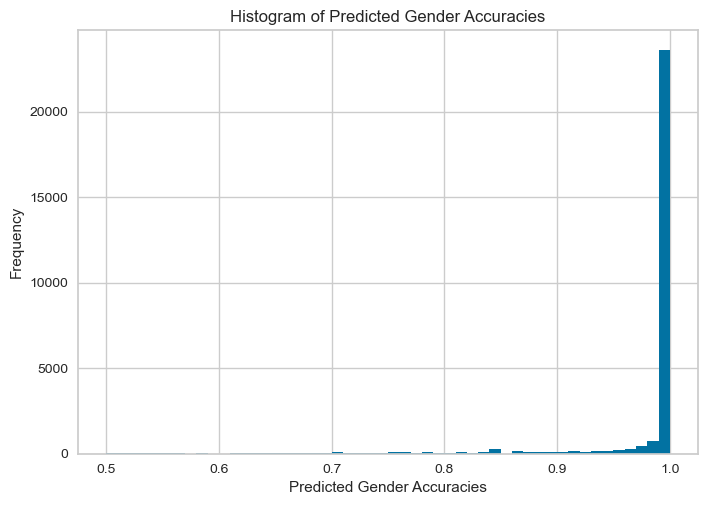

In [66]:
# Histogram of recorded accuracies for each predicted gender
pop_df_complete['Accuracy'].plot.hist(bins=50)
plt.title('Histogram of Predicted Gender Accuracies')
plt.xlabel('Predicted Gender Accuracies')

It's great to see that most of the recorded accuracies are very high. It's also important to remember that these estimated accuracies may not accurately represent how correct the predictions are. One reason for this is that for the nltk classifier, the training data was not very representative of the data that needed predictions.

In [67]:
pop_df_complete[pop_df_complete['Accuracy'] < 0.8].shape[0]/pop_df_complete.shape[0]

0.042716437085147385

In order to ensure that conclusions gathered from this data are more accurate, I will replace the estimated gender with null values for observations with accuracies under 80%. This will only affect around 4% of observations.

In [68]:
pop_df_complete.loc[pop_df_complete['Accuracy'] < 0.8,'Sex at birth'] = ""

Below I will manually correct a few  miss-classifications that I noticed:

In [69]:
pop_df_complete.loc[(pop_df_complete['First Name'] == "Lakshmi") & (pop_df_complete['Last Name'] == "Yatham"),'Sex at birth'] = "Male"
pop_df_complete.loc[(pop_df_complete['First Name'] == "Santa") & (pop_df_complete['Last Name'] == "Ono"),'Sex at birth'] = "Male"
pop_df_complete.loc[(pop_df_complete['First Name'] == "Ali") & (pop_df_complete['Last Name'] == "Lazrak"),'Sex at birth'] = "Male"
pop_df_complete.loc[(pop_df_complete['First Name'] == "Jan") & (pop_df_complete['Last Name'] == "Bena"),'Sex at birth'] = "Female"

Finally, I will export the data to be used to create a Tableau dashboard.

In [70]:
# export dataset
pop_df_complete.to_excel('/Users/jadebouchard/Desktop/UBC Salaries/ubc_salary_deparment_gender_all.xlsx', index = False)

## Data Visualization

Below is a Tableau dashboard showing a visual representation of the data.
The dashboard can also be accessed through this [link](https://public.tableau.com/views/UBCSalary/Dashboard1?:language=en-US&:display_count=n&:origin=viz_share_link).

- The top left graph is a histogram of salary, stacked by gender.
- The top right graph is a bar chart of median salaries, split by job title and gender
- The bottom left graph is a circle bar chart of median salaries split by gender and department
- The bottom right graph is a side-by-side box plot of salaries, split by department

You can hover over a portion of a plot to get exact values. In addition, you can filter by title and department on the right side of the dashboard.

In [71]:
%%HTML
<div class='tableauPlaceholder' id='viz1700094097675' style='position: relative'><noscript><a href='#'><img alt='Dashboard 1 ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;UB&#47;UBCSalary&#47;Dashboard1&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='UBCSalary&#47;Dashboard1' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;UB&#47;UBCSalary&#47;Dashboard1&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='language' value='en-US' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1700094097675');                    var vizElement = divElement.getElementsByTagName('object')[0];                    if ( divElement.offsetWidth > 800 ) { vizElement.style.width='1120px';vizElement.style.minHeight='587px';vizElement.style.maxHeight='687px';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';} else if ( divElement.offsetWidth > 500 ) { vizElement.style.width='1120px';vizElement.style.minHeight='587px';vizElement.style.maxHeight='687px';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';} else { vizElement.style.width='100%';vizElement.style.height='1377px';}                     var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

## Conclusion

In summary, I accomplished my main objective of gaining experience in wrangling data and machine learning. In addition, I was able to visualize the data using an interactive Tableau dashboard. This method of presenting the data seems to be much more user-friendly than the PDF that the University of British Columbia provides.

**Data Analysis**

There are many potential conclusions to be derived from the data presented here. This project stops short at the analysis of the data as the primary objective is to wrangle and visualize the data, which has been accomplished. For future work, an analysis on the statistical significance of salary disparity between genders, titles, and departments would be interesting.

If you are interested in seeing demonstrations of my analysis skills, please check out the following projects on GitHub:
</br>[Forest Fire Impact Prediction Using Linear Regression](https://github.com/jjadeb/Stat_301_Project)
</br>[Impact of Internet Access on Final Grade Using the T-Test](https://github.com/jjadeb/stat-201-project)
</br>[Analysis of Celebrity Age of Death using Stratified Sampling](https://github.com/jjadeb/STAT334-Project)

**Data Limitations**

Any conclusions drawn from the data must take into account the inaccuracies of the department, job title, and gender information. This is partly due to the error involved in clustering and natural language classifiers. In addition, we saw there were many missing data-points for department and title information, therefore the data in the visualization may not accurately represent the entirety of the UBC faculty.

**Final Note**

Overall, this project not only advanced my skills in data manipulation and visualization but also laid the groundwork for future in-depth analyses. I also enhanced my understanding around how data collection and cleaning methods can lead to data limitations, impacting the ability to make meaningful conclusions during analysis.